In [1]:

# wrapper que integra Keras (TensorFlow) com Scikit-Learn para facilitar o uso de GridSearchCV - pois antes o KerasRegressor nao esta funcionando (from keras.wrappers.scikit_learn import KerasRegressor)
# !pip install scikeras

# Acessar os valores das ações, petróleo (brent), ibovespa e minério de ferro
# !pip install yfinance

# Acessar a variável de entrada do fechamento do dólar
# !pip install python-bcb==0.3.3

# Foi preciso dar upgrade para rodar os imports
# !pip install --upgrade scikit-learn

In [2]:
## 1. Importação de Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
import yfinance as yf
from bcb import sgs

# Tempo de compilação, variáveis do sistema e aleatoriedade
import time
import os
import random

In [3]:
## 2. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # controla aleatoriedade interna do interpretador Python
  random.seed(seed) # controla aleatoriedade da biblioteca random
  np.random.seed(seed) # controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida

In [4]:
## 3. Coleta dos Dados

# Tempo inicial de compilação
_start_time = time.time()

# Datas de início e fim das features
start = '2016-09-01'
end = '2023-09-01'

# Dados da SBSP3 (Close e Volume)
vale = yf.download('SBSP3.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
vale.columns = ['Close_SBSP3', 'Volume_SBSP3'] # renomeia a coluna

# Dólar
dolar = sgs.get({'Close_Dolar': 1}, start=start, end=end).reset_index() # faz com que Date deixe de ser index e passe a ser uma coluna junto ao Close_Dolar
dolar['Date'] = pd.to_datetime(dolar['Date']) # muda o type da coluna Date para Datetime para ficar igual as demais variáveis
dolar.set_index('Date', inplace=True) # retorna Date para index, pois é assim que as demais variáveis estão

# Petróleo (WTI) pelo Yahoo Finance
petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
petroleo.columns = ['Close_Petroleo']

# Ibovespa
ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
ibov.columns = ['Close_Ibovespa']

# Minério de Ferro (supondo índice internacional)
minerio = yf.download('RIO', start=start, end=end)[['Close']] # mineradora Rio Tinto
minerio.columns = ['Close_Minerio']

C:\Users\felip\AppData\Local\Temp\ipykernel_17536\2163447700.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vale = yf.download('SBSP3.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
[*********************100%***********************]  1 of 1 completed
C:\Users\felip\AppData\Local\Temp\ipykernel_17536\2163447700.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
[*********************100%***********************]  1 of 1 completed
C:\Users\felip\AppData\Local\Temp\ipykernel_17536\2163447700.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
[*********************100%***********************]  1 of 1 completed
C:\Users\felip

In [5]:
## 4. Preparação e Merge dos Dados

# Unificar tudo em um DataFrame
df = vale.copy() # cria uma cópia do dataframe para ir dando o merge
df = df.merge(dolar, left_index=True, right_index=True, how='left') # junta os dados ao dataframe principal a partir do index (date)
df = df.merge(petroleo, left_index=True, right_index=True, how='left')
df = df.merge(ibov, left_index=True, right_index=True, how='left')
df = df.merge(minerio, left_index=True, right_index=True, how='left')

# Remover valores nulos
df.dropna(inplace=True)

In [6]:
## 5. Normalização

scaler = MinMaxScaler() # usa o minmaxscaler como normalizador para escalar os dados entre 0 e 1
dados_escalados = scaler.fit_transform(df) # aplica o normalizador a todos os dados numéricos

In [7]:
## 6. Criação da Janela Deslizante (21 dias)

def createXY(dataset, n_past): # função que cria as janelas deslizantes
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)): # começa no n_past (=21)
        dataX.append(dataset[i - n_past:i, :]) # para cada ponto no tempo, pega os últimos 'n_past' dias como entrada (X)
        dataY.append(dataset[i, 0]) # a saída (y) será o valor de fechamento da VALE3 no dia seguinte; o índice 0 representa o Close_Vale3 que vai ser a variável de saída (predição)
    return np.array(dataX), np.array(dataY)

X, y = createXY(dados_escalados, 21) # gera os arrays X (entradas) e y (saídas) com uma janela de 21 dias

# Separar treino e teste (80/20)
split = int(len(X) * 0.8) # faz o corte de 80% dos dados
X_train, X_test = X[:split], X[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> X
y_train, y_test = y[:split], y[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> Y

In [8]:
## 7. Construção do Modelo com GridSearchCV (2ª arquitetura)

def build_model(optimizer='adam'): # função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(32, return_sequences=True, input_shape=(15, X_train.shape[2]))) # primeira camada LSTM com 128 neurônios e retorno da sequência para a próxima LSTM
    # model.add(Dropout(0.1)) # dropout após a primeira LSTM (evita overfitting logo na entrada)
    model.add(LSTM(16)) # segunda camada LSTM com 64 neurônios (sem return_sequences, pois é a última LSTM)
    # model.add(Dropout(0.1))
    model.add(Dense(10)) # camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # definição dos hiperparâmetros
    'batch_size': [14, 16, 20, 24], # tamanhos de lote a testar
    'epochs': [60, 70, 80, 90], # número de épocas de treino
    'optimizer': ['adam'] # otimizador usado na compilação
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=4) # inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=3)
grid_result = grid.fit(X_train, y_train) # realiza o treinamento e busca dos melhores parâmetros

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0397
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030
Epoch 6/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 7/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 8/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 9/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020
Epoch 10/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019
Epoch 11/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 12/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 13/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 14/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 15/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 16/60
72/72 ━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0187
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 6/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 7/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 8/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 9/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 10/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 11/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 12/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 13/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 14/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoch 15/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 16/60
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0165
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 6/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 7/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoch 8/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 9/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 10/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 11/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 12/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 13/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 14/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 15/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 16/60
72/72 ━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0198
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023
Epoch 6/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 7/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 8/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 9/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 11/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 13/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 14/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 15/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 16/60
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0230
Epoch 2/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049
Epoch 3/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043
Epoch 4/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 5/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 6/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 7/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 8/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 9/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 10/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019
Epoch 11/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 12/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 13/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 14/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 15/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 16/70
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0350
Epoch 2/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047
Epoch 3/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041
Epoch 4/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 5/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 6/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026
Epoch 7/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024
Epoch 8/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022
Epoch 9/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 10/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 11/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 12/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 13/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 14/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 15/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 16/70
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0175
Epoch 2/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 3/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023
Epoch 4/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 5/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 6/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 7/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 8/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 9/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 10/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 11/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010    
Epoch 12/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.9922e-04
Epoch 13/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.5848e-04
Epoch 14/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1772e-04
Epoch 15/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7656e-04
Epoch 16/7

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0402
Epoch 2/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049
Epoch 3/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037
Epoch 4/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031
Epoch 5/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 6/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 7/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 8/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 9/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 11/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 13/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 14/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 15/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 16/70
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0604
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073
Epoch 3/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056
Epoch 4/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042
Epoch 5/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 6/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026
Epoch 7/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 8/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 9/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 10/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020
Epoch 11/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 12/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 13/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 14/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 15/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 16/80
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0143
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 3/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 4/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023
Epoch 5/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 6/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 7/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 8/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 9/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 10/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 11/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 12/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 13/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 14/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 15/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 16/80
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0071
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 3/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 4/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 5/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 6/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 7/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoch 8/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 9/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 10/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 11/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 12/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 13/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 14/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 15/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010
Epoch 16/80
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0299
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045
Epoch 3/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037
Epoch 4/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 5/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 6/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 7/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 8/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 9/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 10/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 11/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
Epoch 12/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 13/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 14/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 15/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 16/80
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0277
Epoch 2/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051
Epoch 3/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 4/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031
Epoch 5/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026
Epoch 6/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 7/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 8/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 9/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 10/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 11/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 12/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 13/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 14/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 15/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 16/90
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130
Epoch 2/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041
Epoch 3/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 4/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 5/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 6/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 7/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 8/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 9/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 11/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 12/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 13/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 14/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 15/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 16/90
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0132
Epoch 2/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028
Epoch 3/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 4/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 5/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 6/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 7/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 8/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 9/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 10/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011    
Epoch 11/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010    
Epoch 12/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010    
Epoch 13/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7613e-04
Epoch 14/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4239e-04
Epoch 15/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1012e-04
Epoch 

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0202
Epoch 2/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040
Epoch 3/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 4/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 5/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 6/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 7/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 8/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 9/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 11/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 12/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 13/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 14/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 15/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 16/90
72/72 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0501
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 12/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 13/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 14/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 15/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 16/60
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0453
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 12/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 13/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 14/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 16/60
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0221
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 12/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011   
Epoch 13/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010    
Epoch 14/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9852e-04
Epoch 15/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5090e-04
Epoch 16/60
63/

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0505
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 12/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 13/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 14/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 16/60
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0170
Epoch 2/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 3/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040
Epoch 4/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 5/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 6/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 7/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 8/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 9/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 11/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 13/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 14/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 15/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 16/70
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0170
Epoch 2/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035
Epoch 3/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 4/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 5/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 6/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 7/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 8/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 9/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 10/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 11/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 12/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 13/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 14/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 16/70
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0094
Epoch 2/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 3/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 4/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 5/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 6/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 7/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 8/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 9/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 10/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 11/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010    
Epoch 12/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9569e-04
Epoch 13/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5385e-04
Epoch 14/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1454e-04
Epoch 15/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7731e-04
Epoch 16/7

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0364
Epoch 2/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 3/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 4/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 5/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 6/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 7/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 8/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 9/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 10/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 11/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 12/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 13/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 14/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 15/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 16/70
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0535
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 9/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 10/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 11/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 12/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 13/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 14/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 15/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 16/80
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0417
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 9/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 10/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 11/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 13/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 14/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 15/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 16/80
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0222
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 9/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 10/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 11/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011    
Epoch 12/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010    
Epoch 13/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4667e-04
Epoch 14/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9142e-04
Epoch 15/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4303e-04
Epoch 16/8

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0305
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 9/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 10/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 11/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 12/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 13/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 14/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 15/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 16/80
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0224
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 16/90
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 16/90
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0112
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011  
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011    
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9640e-04
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6025e-04
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2525e-04
Epoch 16

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0353
Epoch 2/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054
Epoch 3/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 4/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 5/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 6/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 7/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 8/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 9/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 10/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 11/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 12/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 13/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 14/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/90
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 16/90
63/63 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0406
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 10/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 11/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 12/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 13/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 14/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 15/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 16/60
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0351
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 10/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 11/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 12/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 13/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 14/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 15/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 16/60
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0124
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 10/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 
Epoch 11/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011    
Epoch 12/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 13/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8814e-04
Epoch 14/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2739e-04
Epoch 15/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6757e-04
Epoch 16/

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0305
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 10/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 11/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 13/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 14/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 16/60
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0360
Epoch 2/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063
Epoch 3/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051
Epoch 4/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043
Epoch 5/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038
Epoch 6/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 7/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 8/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 9/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 10/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 11/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 12/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 13/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 14/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 15/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 16/70
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0609
Epoch 2/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077
Epoch 3/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044
Epoch 4/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039
Epoch 5/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 6/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 7/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 8/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 9/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 10/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 11/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021
Epoch 12/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 13/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 14/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 15/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 16/70
50/50 ━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0280
Epoch 2/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052
Epoch 3/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 4/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 5/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 6/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 7/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 8/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 9/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 10/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 11/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 12/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 13/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 14/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 
Epoch 15/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011    
Epoch 16/70
50/50 ━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0307
Epoch 2/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056
Epoch 3/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044
Epoch 4/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 5/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 6/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 7/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 8/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 9/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 10/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 11/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 12/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 13/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 14/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 16/70
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0292
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023
Epoch 10/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 11/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 12/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 13/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 14/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 15/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 16/80
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0538
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 10/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 11/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 12/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 13/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 14/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 15/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 16/80
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0223
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 10/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 11/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 12/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 13/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 
Epoch 14/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011  
Epoch 15/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011    
Epoch 16/80
50/50 ━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0247
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 10/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 11/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 12/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 13/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 14/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 15/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 16/80
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0281
Epoch 2/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057
Epoch 3/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048
Epoch 4/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 5/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 6/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 7/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 8/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 9/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 10/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 11/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 12/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 13/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 14/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 15/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 16/90
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0123
Epoch 2/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043
Epoch 3/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 4/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 5/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 6/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 7/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 8/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 9/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 10/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 11/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 12/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 13/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 14/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 15/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 16/90
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0244
Epoch 2/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044
Epoch 3/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 4/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 5/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 6/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 7/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 8/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 9/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 10/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 11/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 12/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 13/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 14/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 15/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011  
Epoch 16/90
50/50 ━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0335
Epoch 2/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053
Epoch 3/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038
Epoch 4/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032
Epoch 5/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 6/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021
Epoch 7/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 8/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 9/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 10/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 11/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 12/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 13/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 14/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 16/90
50/50 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0601
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 9/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 10/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 11/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 12/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 13/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 14/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 15/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 16/60
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0437
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 9/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 10/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 11/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 12/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 13/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 14/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 15/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 16/60
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0197
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 9/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 10/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 11/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 12/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011  
Epoch 13/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011    
Epoch 14/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 15/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 16/60
42/

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0158
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 9/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 10/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 11/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 12/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 13/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 14/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 15/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 16/60
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0349
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 8/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 9/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 10/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 11/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021
Epoch 12/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 13/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 14/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 15/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 16/70
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0517
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 8/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 9/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 10/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 11/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 12/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 13/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 14/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 15/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 16/70
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0549
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 8/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 9/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 10/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 11/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 12/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 
Epoch 13/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 14/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 15/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 16/70
42/42 ━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0496
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 8/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 9/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 10/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 11/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 12/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 13/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 14/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 16/70
42/42 ━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0138
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 9/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022
Epoch 10/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 11/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 12/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 13/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 14/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 15/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 16/80
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0740
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 9/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 10/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 11/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 12/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 13/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 14/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 15/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 16/80
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0163
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 
Epoch 9/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 
Epoch 10/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 11/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 
Epoch 12/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 13/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011    
Epoch 14/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010    
Epoch 15/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6335e-04
Epoch 16/80
4

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0343
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 9/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 10/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 11/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 12/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 13/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 14/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 15/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 16/80
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0759
Epoch 2/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078
Epoch 3/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055
Epoch 4/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049
Epoch 5/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045
Epoch 6/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 7/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038
Epoch 8/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 9/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 10/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028
Epoch 11/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 12/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 13/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 14/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021
Epoch 15/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 16/90
42/42 ━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0713
Epoch 2/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106
Epoch 3/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050
Epoch 4/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 5/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 6/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 7/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 8/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 9/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 10/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 11/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 12/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 13/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 14/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 15/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 16/90
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0163
Epoch 2/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054
Epoch 3/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036
Epoch 4/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
Epoch 5/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024
Epoch 6/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 7/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 8/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 9/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 10/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 11/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 12/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 13/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 14/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 
Epoch 15/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011   
Epoch 16/90
42/42 ━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0314
Epoch 2/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064
Epoch 3/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 4/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 5/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 6/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 7/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 8/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 9/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 10/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 11/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 12/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 13/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 14/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 15/90
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 16/90
42/42 ━━━━━━━━━━━━

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0177
Epoch 2/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Epoch 3/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 4/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025
Epoch 5/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 6/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019
Epoch 7/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 8/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 9/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 10/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 11/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 12/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 13/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 14/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 15/80
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 16/80
84/84 ━━━━━━━━━━━━

In [9]:
## 8. Avaliação do Modelo

best_model = grid_result.best_estimator_ # recupera o melhor modelo encontrado pelo GridSearchCV
pred = best_model.predict(X_test) # faz a predição dos valores do conjunto de teste

# Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [10]:
## 9. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 0.8643612204911469
MAPE: 0.018138917716036183
R²: 0.948917235766454


In [11]:
resultados = pd.DataFrame(grid_result.cv_results_)
display(resultados[['params', 'mean_test_score', 'rank_test_score']])

,params,mean_test_score,rank_test_score
0,"{'batch_size': 14, 'epochs': 60, 'optimizer': ...",0.860562,7
1,"{'batch_size': 14, 'epochs': 70, 'optimizer': ...",0.781985,11
2,"{'batch_size': 14, 'epochs': 80, 'optimizer': ...",0.671907,16
3,"{'batch_size': 14, 'epochs': 90, 'optimizer': ...",0.853624,8
4,"{'batch_size': 16, 'epochs': 60, 'optimizer': ...",0.691127,15
5,"{'batch_size': 16, 'epochs': 70, 'optimizer': ...",0.827852,9
6,"{'batch_size': 16, 'epochs': 80, 'optimizer': ...",0.909901,1
7,"{'batch_size': 16, 'epochs': 90, 'optimizer': ...",0.907289,2
8,"{'batch_size': 20, 'epochs': 60, 'optimizer': ...",0.791187,10
9,"{'batch_size': 20, 'epochs': 70, 'optimizer': ...",0.872748,5


In [12]:
grid_result.best_params_

{'batch_size': 16, 'epochs': 80, 'optimizer': 'adam'}

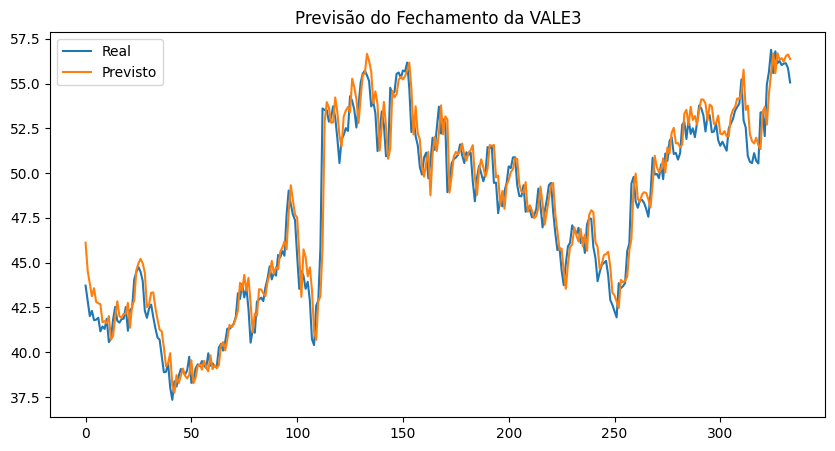

In [13]:
## 10. Gráfico

plt.figure(figsize=(10,5))
plt.plot(y_real, label='Real')
plt.plot(pred_real, label='Previsto')
plt.legend()
plt.title('Previsão do Fechamento da VALE3')
plt.show()

In [14]:
## 11. Tempo Final de Compilação
_end_time = time.time() - _start_time
print(f"Tempo total de execução: {_end_time:.2f} segundos")

Tempo total de execução: 2249.79 segundos
